# Hub'Eau time series univariate forecasting

Setup our working environment first in order to be able to visualise data and make training/prediction:

In [144]:
import sys
sys.path.append('..')

# This ensures that modules are reloaded while developing
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data processing

In [145]:
from src.data import read_raw_data

Read raw data from a station to be used for training the model and display it:

array([<AxesSubplot:xlabel='date_obs'>], dtype=object)

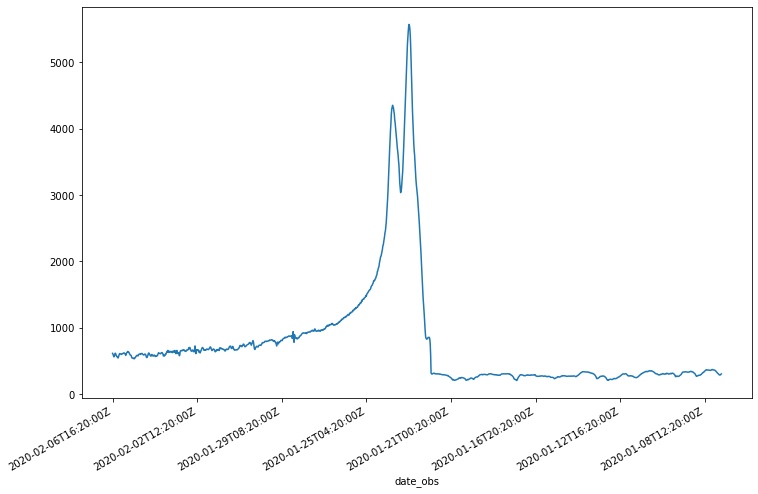

In [146]:
data = read_raw_data("../data/raw/train_data/hubeau_site_Y1422030_30d_30m_L'Aude.csv")
data.head()
data.plot(subplots=True)

Read data from a station at a different time period to be used for validating the model and display it:

array([<AxesSubplot:xlabel='date_obs'>], dtype=object)

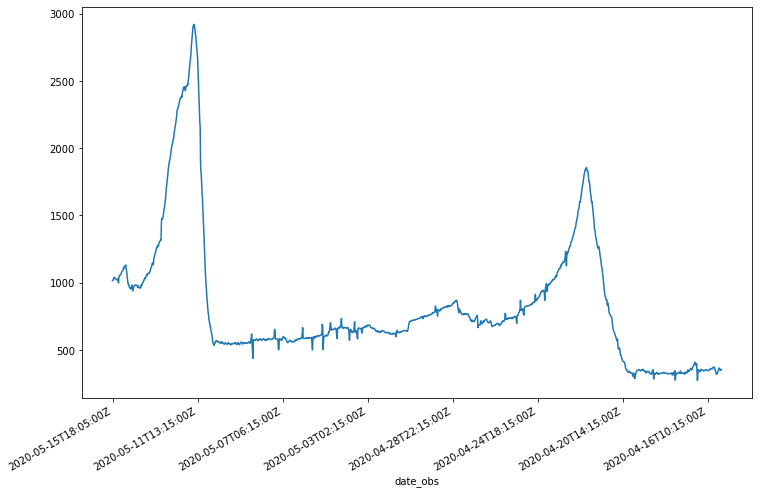

In [147]:
validation_data = read_raw_data("../data/raw/validation_data/hubeau_site_Y1422030_2020-04-15_30d_30m_L'Aude.csv")
validation_data.head()
validation_data.plot(subplots=True)

We will work with two setups:
* a **single-step** setup where the model learns to predict a single point in the future based on some history provided
* a **multi-step** setup where given a past history the model needs to learn to predict a range of future values 

Let's say you want to predict the water level 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 240 (5x48) observations to train the model if your time step is 30 minutes (2 observations per hour). Many such configurations are possible, making this dataset a good one to experiment with.

The `data_windows` function returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict, ie the label(s) that needs to be predicted: a single value for single-step setup and a set of values for multi-step setup.

We can keep 75% of the training dataset to train and the remaining 25% would be the validation data. However, we prefer to use two really different datasets in order to ensure our model is generalizing correctly to unseen data. We split our validation dataset into two parts, 50% for training validation and 50% we will use to test the model against unseen data.

First we need to standardize the data (i.e. transform data to have a mean of zero and a standard deviation of 1):

In [148]:
print('Training dataset length is {}'.format(data.size))
mean = data.values.mean()
std = data.values.std()
print ('Training Mean value {} - Std value {}'.format(mean, std))
ndata = normalize(data.values, mean, std)

print('Validation dataset length is {}'.format(validation_data.size))
vmean = validation_data.values.mean()
vstd = validation_data.values.std()
print ('Validation Mean value {} - Std value {}'.format(vmean, vstd))
nvdata = normalize(validation_data.values, mean, std)

Training dataset length is 1440
Training Mean value 764.8993055555555 - Std value 867.8262052389971
Validation dataset length is 1432
Validation Mean value 822.6382681564246 - Std value 491.7656981039218


## Single-step model

We first start with the single step setup: the model learns to predict a single point in the future based on some history provided. Let's now create the data for the model, it will be given the last N recorded observations (eg 24 observations - 12H if your time step is 30 minutes), and needs to learn to predict the level in Y hours (eg 8 observations - 4H ahead if your time step is 30 minutes).

Timestep 30m - History 12h - Looking 240m ahead
Sample window [-0.17272964 -0.18540499 -0.21075568 -0.23149716 -0.22919256 -0.20499416
 -0.17157733 -0.17157733 -0.19692803 -0.20729877 -0.22804025 -0.23495408
 -0.2395633  -0.25339095 -0.23495408 -0.21075568 -0.18655729 -0.17618655
 -0.18079577 -0.18194807 -0.18540499 -0.19116651 -0.18540499 -0.17964346]
Target level value -0.19692803066310993


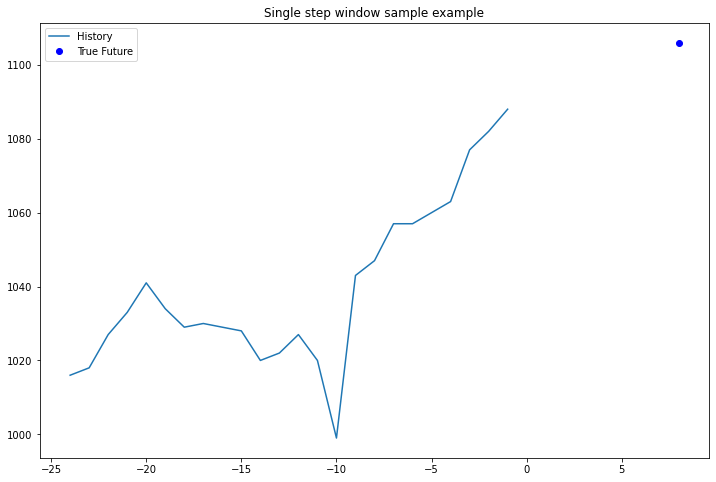

In [149]:
from src.visualisation import show_single_plot

timestep = 30 # in minutes, can be 10, 30 or 60
perHour = round(60 / timestep) # number of observation per hour
history = (12 * perHour) # N hours history
future = (4 * perHour) # Predict N hours ahead

print ('Timestep {}m - History {}h - Looking {}m ahead'.format(timestep, round(history / perHour), future*timestep))

x_train_single, y_train_single = data_windows(ndata, history, future, single_step=True)
x_validate_single, y_validate_single = data_windows(nvdata, history, future, single_step=True)

print ('Sample window {}'.format(x_train[0].flatten()))
print ('Target level value {}'.format(y_train[0]))

show_single_plot(x_validate_single[0], y_validate_single[0], future, None, 'Single step window sample example', mean, std)

### Model fitting

We will fit a Recurrent Neural Network (RNN), which is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. In this experiment, we will use a specialized RNN layer called Long Short Term Memory (LSTM).

In [150]:
from src.modelling import fitRNN

(model_single, model_single_history) = fitRNN(x_train_single, y_train_single, x_validate_single, y_validate_single)

Epoch 1/10
100/100 [==============================] - 2s 23ms/step - loss: 0.2831 - mse: 0.3926 - val_loss: 0.1267 - val_mse: 0.1213
Epoch 2/10
100/100 [==============================] - 2s 18ms/step - loss: 0.1139 - mse: 0.1335 - val_loss: 0.1512 - val_mse: 0.1849
Epoch 3/10
100/100 [==============================] - 2s 17ms/step - loss: 0.1059 - mse: 0.1095 - val_loss: 0.1381 - val_mse: 0.1393
Epoch 4/10
100/100 [==============================] - 2s 17ms/step - loss: 0.0935 - mse: 0.0839 - val_loss: 0.1113 - val_mse: 0.0780
Epoch 5/10
100/100 [==============================] - 2s 18ms/step - loss: 0.0866 - mse: 0.0726 - val_loss: 0.1084 - val_mse: 0.0692
Epoch 6/10
100/100 [==============================] - 2s 17ms/step - loss: 0.0791 - mse: 0.0626 - val_loss: 0.0821 - val_mse: 0.0330
Epoch 7/10
100/100 [==============================] - 2s 17ms/step - loss: 0.0738 - mse: 0.0554 - val_loss: 0.0844 - val_mse: 0.0364
Epoch 8/10
100/100 [==============================] - 2s 17ms/step - 

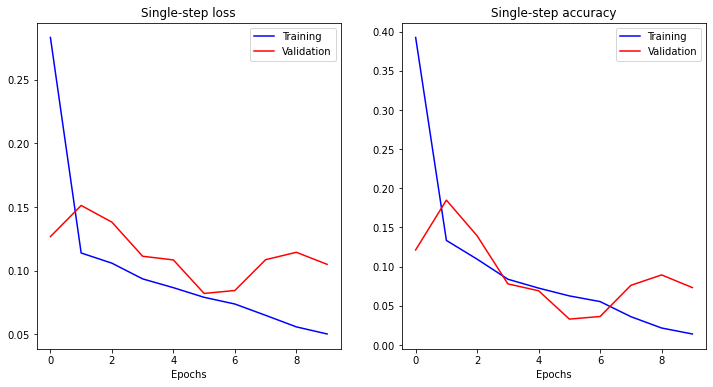

In [151]:
from src.visualisation import plot_train_metric

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_train_metric(model_single_history, 'Single-step loss', 'loss')
plt.subplot(122)
plot_train_metric(model_single_history, 'Single-step accuracy', 'mse')

In Keras the loss is calculated as a moving average over all processed batches, meaning that in the early training stage when loss drops quickly the first batch of an epoch will have a much higher loss than the last. When the epoch is finished, the shown training loss will NOT represent the training loss at the end of the epoch but the average training loss from start to end of the epoch. Therefore, it's often times higher than the validation loss, which is calculated at the end of the epoch entirely.

Fundamental rules:
- validation loss >> training loss => overfitting.
- validation loss  > training loss => some overfitting.
- validation loss  < training loss => some underfitting.
- validation loss << training loss => it underfitting.

Model is fitting very nicely the training data but not at all the validation data when overfitting occurs, in other words it's not generalizing correctly to unseen data. If both losses end up to be roughly the same, and if the values are converging, then chances are very high that we are doing it right.

### Model evaluation

Now see how it performs globally on a flood period:

Mean Absolute Error 44.56
Max Absolute Error 72.78
Mean Absolute Percentage Error 4.42%
Max Absolute Percentage Error 24.43%
Mean Squared Error 6320.15
Root Mean Squared Error 79.50


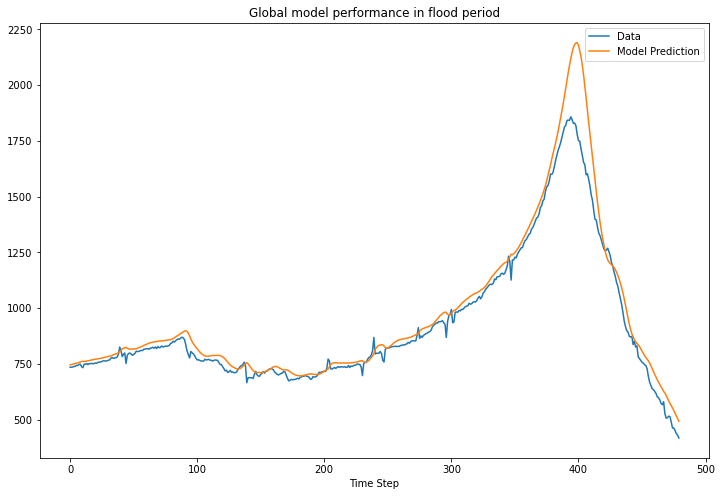

In [152]:
from src.modelling import predictRangeRNN

flood_start = 15 * 24 * perHour # 15 days after start period
flood_end = 25 * 24 * perHour # 25 days after start period
ground_truth, prediction = predictRangeRNN(model_single, validation_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance in flood period')

Then see how it performs globally on another station:

Mean Absolute Error 370.34
Max Absolute Error 2061.20
Mean Absolute Percentage Error 16.25%
Max Absolute Percentage Error 94.73%
Mean Squared Error 327752.94
Root Mean Squared Error 572.50


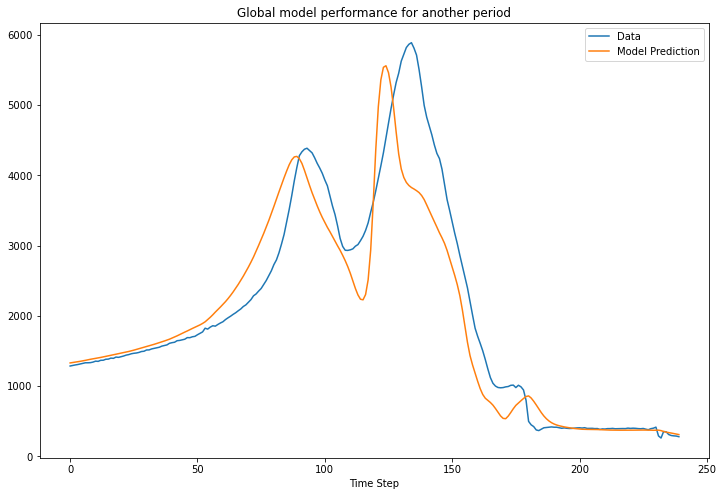

In [153]:
# Data for testing at another but near station
test_raw = pd.read_csv("../data/raw/train_data/hubeau_site_Y1232010_30d_30m_L'Aude.csv", delimiter=';')
test_data = test_raw['resultat_obs']
test_data.index = test_raw['date_obs']
test_data.head()

flood_start = 12 * 24 * perHour # 12 days after start period
flood_end = 17 * 24 * perHour # 17 days after start period
ground_truth, prediction = predictRangeRNN(model_single, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another period')

And another period:

Mean Absolute Error 48.22
Max Absolute Error 61.83
Mean Absolute Percentage Error 4.31%
Max Absolute Percentage Error 29.47%
Mean Squared Error 8935.63
Root Mean Squared Error 94.53


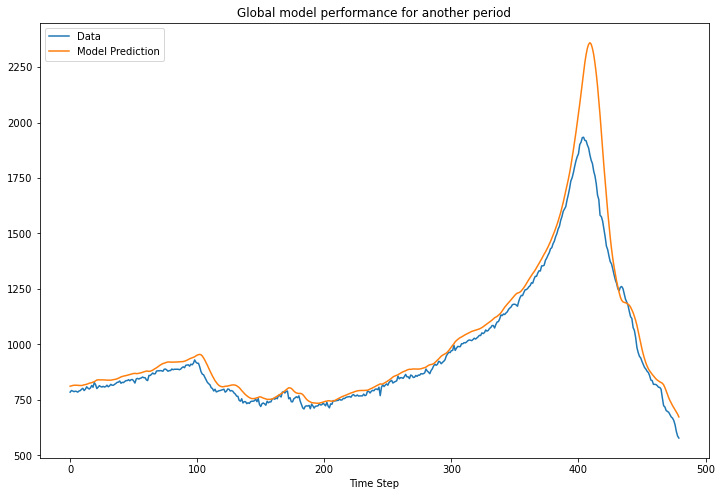

In [161]:
# Data for testing at another but near station
test_raw = pd.read_csv("../data/raw/validation_data/hubeau_site_Y1232010_2020-04-15_30d_30m_L'Aude.csv", delimiter=';')
test_data = test_raw['resultat_obs']
test_data.index = test_raw['date_obs']
test_data.head()

flood_start = 15 * 24 * perHour # 12 days after start period
flood_end = 25 * 24 * perHour # 17 days after start period
ground_truth, prediction = predictRangeRNN(model_single, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another period')

## Multi-step model

We will then work with the multi-step setup, ie given a past history, the model needs to learn to predict a range of future values. Data setup and model training is pretty similar except since the task here is a bit more complicated than the previous task, the model can consist of more LSTM layers.

Sample window [-0.17272964 -0.18540499 -0.21075568 -0.23149716 -0.22919256 -0.20499416
 -0.17157733 -0.17157733 -0.19692803 -0.20729877 -0.22804025 -0.23495408
 -0.2395633  -0.25339095 -0.23495408 -0.21075568 -0.18655729 -0.17618655
 -0.18079577 -0.18194807 -0.18540499 -0.19116651 -0.18540499 -0.17964346]
Target level value -0.19692803066310993


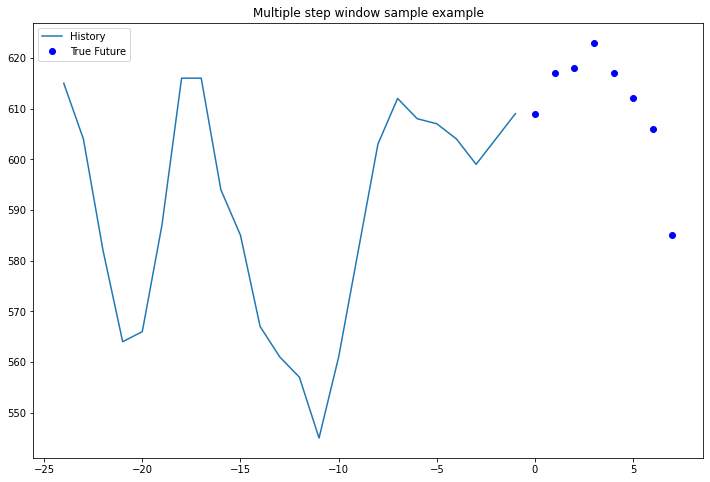

In [155]:
from src.visualisation import show_multiple_plot

x_train_multiple, y_train_multiple = data_windows(ndata, history, future, single_step=False)
x_validate_multiple, y_validate_multiple = data_windows(nvdata, history, future, single_step=False)

print ('Sample window {}'.format(x_train[0].flatten()))
print ('Target level value {}'.format(y_train[0]))

show_multiple_plot(x_train_multiple[0], y_train_multiple[0], np.empty([0]), 'Multiple step window sample example', mean, std)

### Model fitting

In [156]:
from src.modelling import fitRNN

(model_multiple, model_multiple_history) = fitRNN(x_train_multiple, y_train_multiple, x_validate_multiple, y_validate_multiple, future)

Epoch 1/10
100/100 [==============================] - 2s 24ms/step - loss: 0.3780 - mse: 0.6882 - val_loss: 0.1668 - val_mse: 0.1364
Epoch 2/10
100/100 [==============================] - 2s 18ms/step - loss: 0.1566 - mse: 0.2165 - val_loss: 0.0942 - val_mse: 0.0486
Epoch 3/10
100/100 [==============================] - 2s 18ms/step - loss: 0.0957 - mse: 0.0832 - val_loss: 0.0777 - val_mse: 0.0332
Epoch 4/10
100/100 [==============================] - 2s 18ms/step - loss: 0.0720 - mse: 0.0451 - val_loss: 0.0627 - val_mse: 0.0215
Epoch 5/10
100/100 [==============================] - 2s 18ms/step - loss: 0.0574 - mse: 0.0264 - val_loss: 0.0529 - val_mse: 0.0143
Epoch 6/10
100/100 [==============================] - 2s 17ms/step - loss: 0.0531 - mse: 0.0209 - val_loss: 0.0517 - val_mse: 0.0148
Epoch 7/10
100/100 [==============================] - 2s 18ms/step - loss: 0.0488 - mse: 0.0177 - val_loss: 0.0453 - val_mse: 0.0114
Epoch 8/10
100/100 [==============================] - 2s 18ms/step - 

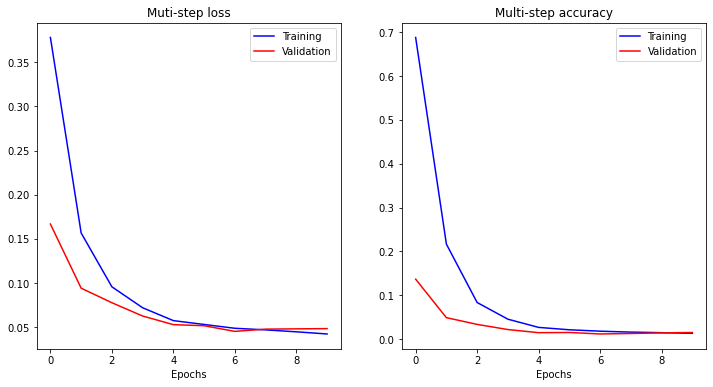

In [157]:
from src.visualisation import plot_train_metric

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_train_metric(model_multiple_history, 'Muti-step loss', 'loss')
plt.subplot(122)
plot_train_metric(model_multiple_history, 'Multi-step accuracy', 'mse')

### Model evaluation

Now see how it performs globally on a flood period:

Mean Absolute Error 17.45
Max Absolute Error 118.41
Mean Absolute Percentage Error 2.03%
Max Absolute Percentage Error 13.14%
Mean Squared Error 723.25
Root Mean Squared Error 26.89


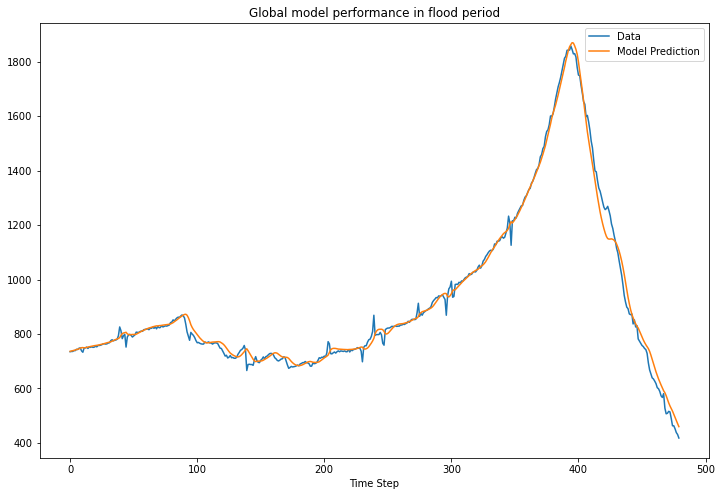

In [158]:
from src.modelling import predictRangeRNN

flood_start = 15 * 24 * perHour # 15 days after start period
flood_end = 25 * 24 * perHour # 25 days after start period
ground_truth, prediction = predictRangeRNN(model_multiple, validation_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance in flood period')

Then see how it performs globally on another station:

Mean Absolute Error 74.71
Max Absolute Error 396.72
Mean Absolute Percentage Error 5.77%
Max Absolute Percentage Error 80.52%
Mean Squared Error 14236.44
Root Mean Squared Error 119.32


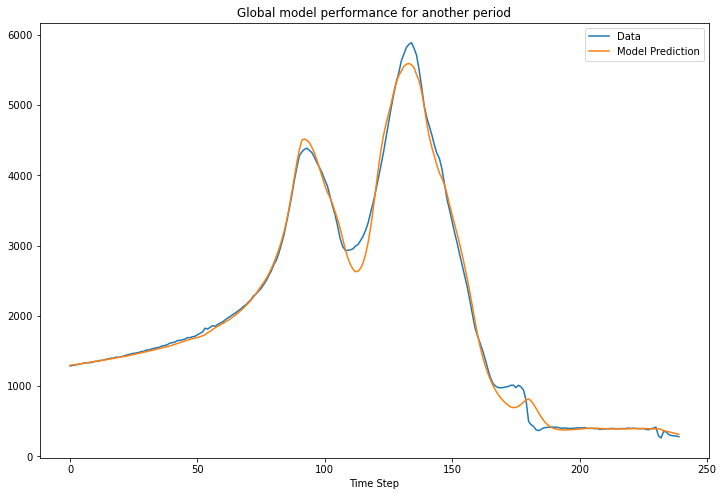

In [159]:
from src.modelling import predictRangeRNN

# Data for testing at another but near station
test_raw = pd.read_csv("../data/raw/train_data/hubeau_site_Y1232010_30d_30m_L'Aude.csv", delimiter=';')
test_data = test_raw['resultat_obs']
test_data.index = test_raw['date_obs']
test_data.head()

flood_start = 12 * 24 * perHour # 12 days after start period
flood_end = 17 * 24 * perHour # 17 days after start period
ground_truth, prediction = predictRangeRNN(model_multiple, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another period')

And another period:

Mean Absolute Error 15.90
Max Absolute Error 120.72
Mean Absolute Percentage Error 1.63%
Max Absolute Percentage Error 11.99%
Mean Squared Error 709.83
Root Mean Squared Error 26.64


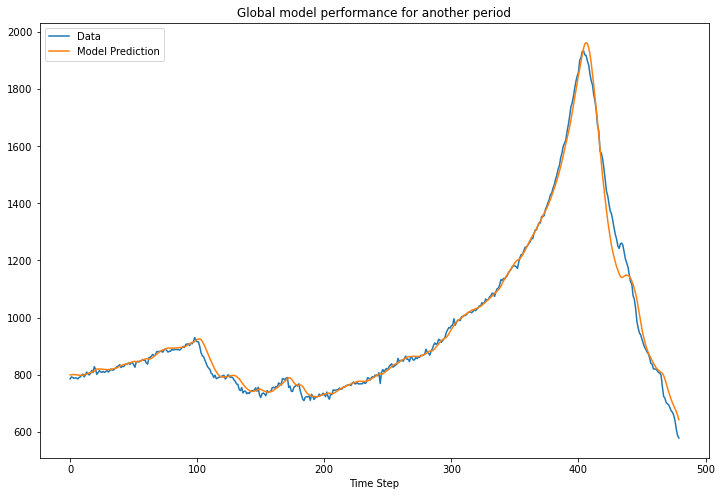

In [162]:
from src.modelling import predictRangeRNN

# Data for testing at another but near station
test_raw = pd.read_csv("../data/raw/validation_data/hubeau_site_Y1232010_2020-04-15_30d_30m_L'Aude.csv", delimiter=';')
test_data = test_raw['resultat_obs']
test_data.index = test_raw['date_obs']
test_data.head()

flood_start = 15 * 24 * perHour # 12 days after start period
flood_end = 25 * 24 * perHour # 17 days after start period
ground_truth, prediction = predictRangeRNN(model_multiple, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another period')